This Jupyter notebook is aimed to help produce ternary density plots from Principal Moments of Inertia (<i>NPR1</i> and <i>NPR2</i>)<br>
<b>Meyers et al., 'On The Origins of Three-Dimensionality in Drug-like Molecules', Future Med. Chem. 2016<br></b>
<i>Notebook Author</i>: Joshua Meyers 2nd April 2016

In [8]:
# This workflow is based on the python-ternary library, this can be installed via pip
# see: https://github.com/marcharper/python-ternary
import ternary
from ternary.helpers import simplex_iterator

# Other requirements:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# requires either pandas OR rdkit installed to read in data
import pandas as pd
from rdkit import Chem

<b>Get data</b><br>
2 methods for reading in data are given below - from csv or sdf


In [6]:
# EITHER: Read in data from csv
infile = '/path/to/input/file.csv' #input data

ternary_list=[]
df = pd.read_csv(infile)
df = df[np.isfinite(df['npr1'])] # case sensitive column name - edit throughout as required
for npr1, npr2 in zip(df['npr1'], df['npr2']):
    if np.isnan(npr1): continue #skip values that are not numbers
    npr1=round(npr1, 2)
    npr2=round(npr2, 2)
    sphere_likeness = (npr1+npr2)-1
    rod_likeness =  (npr2-npr1)
    disc_likeness = 2-(2*npr2)
    ternary_list.append((sphere_likeness, disc_likeness, rod_likeness))
print 'number of data points loaded: ', len(ternary_list)

In [9]:
# OR: Read in data from sdf file
infile = '/path/to/input/file.sdf' #input data

ternary_list=[]
suppl = Chem.ForwardSDMolSupplier(infile, sanitize=True, removeHs=True)
for mol in suppl:
    if mol is None: continue
    if not mol.HasProp('npr1'): continue # case sensitive property name - edit throughout as required
    npr1 = round(float(mol.GetProp('npr1')), 2)
    npr2 = round(float(mol.GetProp('npr2')), 2)
    if np.isnan(npr1): continue #skip values that are not numbers
    sphere_likeness = (npr1+npr2)-1
    rod_likeness =  (npr2-npr1)
    disc_likeness = 2-(2*npr2)    
    ternary_list.append((sphere_likeness, disc_likeness, rod_likeness))
print 'number of data points loaded: ', len(ternary_list)

83367


Split data into ternary bins and assess frequency of each bin

In [11]:
# Split data into bins with width 1/scale
scale = 25 # number of bins along each axis
bins = np.linspace(0,1,scale+1)[1:]

# digitize returns the index of the bin to which a value was assigned
x_inds = list(np.digitize(np.array([i[0] for i in ternary_list]), bins))
y_inds = list(np.digitize(np.array([i[1] for i in ternary_list]), bins))
z_inds = list(np.digitize(np.array([i[2] for i in ternary_list]), bins))
ternary_list_binned = zip(x_inds, y_inds, z_inds)

In [12]:
# Populate ternary_dict with {(i,j,k):frequency}
ternary_dict = dict()

# Initiate all possible (i,j,k) vertices (only keep i and j as k is implied by these)
for (i,j,k) in simplex_iterator(scale):
    ternary_dict[(i,j)] = 0

# Count number of occurences of each (i,j,k) in binned data
for i,j,k in ternary_list_binned:
    ternary_dict[(i,j)]+=1

In [13]:
# Create a log scale for the frequency (optional)
log_dict = {}
for key, value in ternary_dict.items():
    if value==0: log_dict[key]=-0.1
    else: log_dict[key]=np.log10(value)
ternary_dict = log_dict

Plot PMI ternary density plot

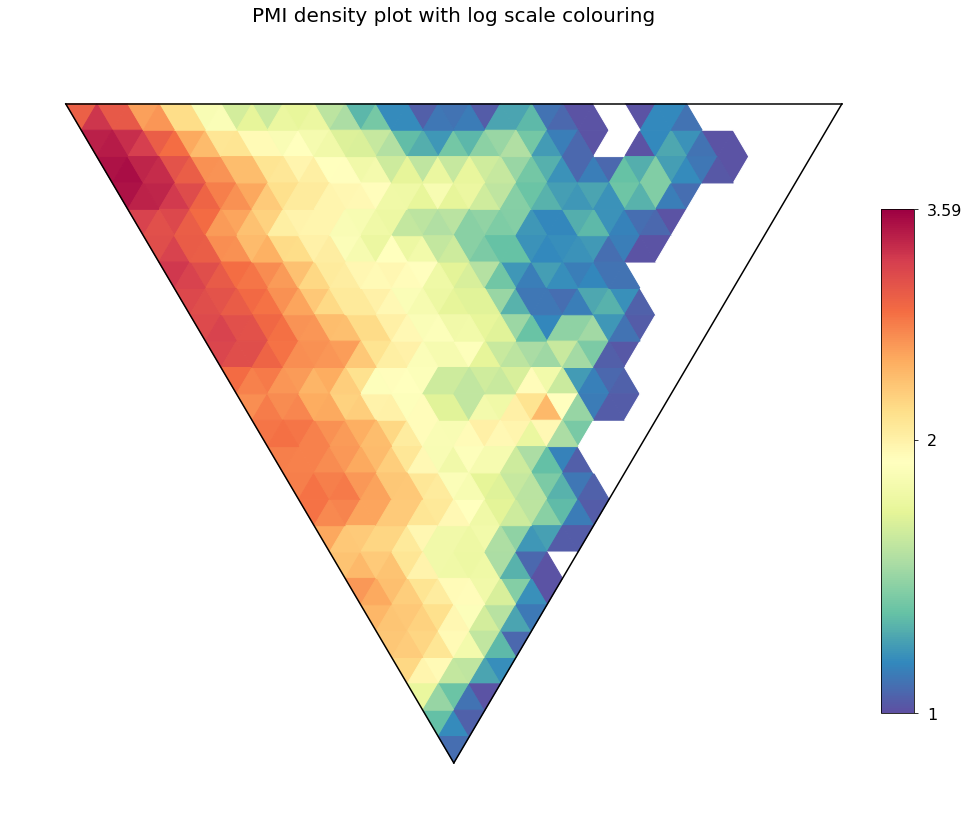

In [25]:
# Set up figure
figure, ax = plt.subplots()
tax = ternary.TernaryAxesSubplot(ax=ax, scale=scale)

# Sizing, borders and title
plt.axis('off') #turn border off
figure.set_size_inches(15.3, 14)
tax.set_title("PMI density plot with log scale colouring", fontsize=20)
tax.boundary(linewidth=1.5)

# Get colormap with white below vmin (eps)
# Other colormaps can be found here: http://matplotlib.org/users/colormaps.html
cmap_whiteZero = matplotlib.cm.get_cmap('Spectral_r')
cmap_whiteZero.set_under('w')
eps = np.spacing(0.0)

# Plot ternary heatmap
tax.heatmap(ternary_dict, style="t", cmap=cmap_whiteZero, vmin=eps, colorbar=False) # style can be t, d, or h (see documentation)
# tax.gridlines(color="0.2", multiple=1, linewidth=0.8, linestyle='-') #uncomment for gridlines
figure.gca().invert_yaxis() #turn plot upside down

# Add colorbar manually so that ticks can be set with log scale
# If not using log scale, comment this section and change 'colorbar' in heatmap function above to True
f_max = round(np.max(ternary_dict.values()), 2)
tick_labels = sorted([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, f_max])
tick_positions = np.log10(np.array(tick_labels))
# Next part is adapted from colorbar_hack function of python-ternary library
ax = tax.get_axes()
norm = plt.Normalize(vmin=eps, vmax=tick_positions[tick_labels.index(f_max)])
sm = plt.cm.ScalarMappable(cmap=cmap_whiteZero, norm=norm)
# Fake up the array of the scalar mappable. Urgh...
sm._A = []
cax = figure.add_axes([0.9, 0.2, 0.03, 0.5]) # (x position, y position, width, height)
cb = plt.colorbar(sm, cax=cax)
cb.set_ticks(tick_positions)
cb.set_ticklabels(tick_labels)
cb.ax.tick_params(labelsize=16, color='black', pad=10)
cb.solids.set_edgecolor("face") # this is needed to improve colorbar quality in vector formats

# Save figure in vector format
# plt.savefig('/Path/To/TernaryDensityPlot_example.eps') # output data